<a href="https://colab.research.google.com/github/sadiq1419/My-Deep-Learning-Nanodegree/blob/master/adversarial_testing_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Notes:

1. Adversarial training is expensive since the DNN needs a lot more training and, preferably, more data to get good accuracy across the domains. It also seems that pre-trained models struggle with adversarial training since it is not enough to replace the classifier. We need to train the convolutional layers to detect the features through the added pertubation noise. This is just my guess; we still need more testing to confirm it.

2. It turns out that the PyTorch random_split function does not balance the data set, and therefore you can run into the case that the test and/or validation set actually does not represent the whole dataset. This caused the DNN to perform badly at the test and/or validation.

3. This notebook and the model training took way longer than expected due to some really stupid mistakes by me. So, sorry about that.

# TODOs:
1. Implement the relaxation of the adversarial loss function from Chapter 4.

2. balance out the dataset spliting or find an alternative data set. The Food 101 set seems like it's worth a try.

3. Implement gradient-cam to see if the model is actually learning new features from the adversarial training. There seems to be an already-made gradient-cam package, but I did not have the time to try it.

## Have a look around the notebook and try things out. Use pre-trained models and see what happens. I have tried vgg19, but like stated above, the whole model needs to be fine-tuned or trained again to capture the features with the added pertubation noise.


# install packages and download dataset

In [1]:
!pip install tqdm
!pip install torchsummaryX
!gdown 1GldRBnDbsFU_U8Gw9UJrpqzzBfobIL9K # from my drive
!unzip /content/PACS.zip

Streaming output truncated to the last 5000 lines.
  inflating: pacs_data/pacs_data/photo/guitar/063_0046.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0047.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0048.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0049.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0050.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0051.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0052.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0053.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0054.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0055.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0056.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0059.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0061.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0062.jpg  
  inflating: pacs_data/pacs_data/photo/guitar/063_0065.jpg  
  inflating: pacs_data/pacs_data/p

# imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

from torchsummaryX import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms, datasets
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, random_split

In [3]:
# check for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset

the PACS dataset has for catagories of images, **P**hotos, **A**rt paintings, **C**artoon and **S**ketchs.

Each catagory has 7 classes:

1. dog
2. elephant
3. giraffe
4. guitar
5. horse
6. house
7. person


The **Full_PACS** loads all the four main catagories. While the **Partial_PACS** loads only one of them



In [4]:
class Full_PACS(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = os.path.join(root_dir)
        self.types = sorted(os.listdir(root_dir))
        self.transform = transform
        self.classes_index = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
        self.classes_name = inv_map = {v: k for k, v in self.classes_index.items()}
        self.num_classes = len(self.classes_index)
        # Make sure that line below is the last thing to run
        # it so that the other attribute get defined first since the loading my depened on them
        self.data = self._load_data()

    def _load_data(self):
        data = []
        for t in self.types:
            for category in sorted(os.listdir(os.path.join(self.root_dir,t))):
                category_dir = os.path.join(self.root_dir,t,category)
                if not os.path.isdir(category_dir):
                    continue
                for filename in os.listdir(category_dir):
                    data.append((os.path.join(category_dir, filename),self.classes_index[category]))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = datasets.folder.default_loader(image_path)

        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
class Partial_PACS(Dataset):
    def __init__(self, root_dir,im_type, transform=None):
        self.im_type = im_type
        self.root_dir = os.path.join(root_dir,self.im_type)
        self.categories = sorted(os.listdir(self.root_dir))
        self.transform = transform
        self.classes_index = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
        self.classes_name = inv_map = {v: k for k, v in self.classes_index.items()}
        self.num_classes = len(self.classes_index)
        # Make sure that line below is the last thing to run
        # it so that the other attribute get defined first since the loading my depened on them
        self.data = self._load_data()

    def _load_data(self):
        data = []
        for category in self.categories:
            category_dir = os.path.join(self.root_dir, category)
            if not os.path.isdir(category_dir):
                continue
            for filename in os.listdir(category_dir):
                data.append((os.path.join(category_dir, filename), self.categories.index(category)))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = datasets.folder.default_loader(image_path)

        if self.transform:
            image = self.transform(image)
        return image, label

# Utilites functions

In [6]:
# Mean and standard deviation used for VGG normalization.
# This an artifact from previos verions but I still use it for the transformations
# probably should not use it but will fix it later
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def unnormalize(image_tensor):
    # Unnormalize the image tensor
    image_array = image_tensor.clone().detach()
    for i in range(3):
        image_array[i] = (image_array[i] * std[i]) + mean[i]
    return image_array

def display_tensor_image(image_tensor):
    if torch.is_tensor(image_tensor):
        image_array = unnormalize(image_tensor).permute(1, 2, 0).numpy()
    else:
        raise ValueError("Input should be a torch.Tensor.")

    plt.imshow(image_array)
    plt.axis('off')


def test_loaders(loader,classes):
    sample = next(iter(loader))
    im,lable = sample[0][0],sample[1][0]
    print(classes[lable.item()])
    display_tensor_image(im)

def DNN_tests(model_path,test_loader,DG_loader,*model_init,heading=None):
    model = myCNN(*model_init)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # normal test
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_normal(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f"{heading}: test set Accuracy: {accuracy:.2f}%")

    # the DG cartoon set
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in DG_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_normal(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{heading}: DG set Accuracy: {accuracy:.2f}%")

def plot_losses(losses):

    plt.figure(figsize=(10, 5))
    plot_range = range(len(losses[0]))
    plt.plot(plot_range, losses[0], label='Training Loss')
    plt.plot(plot_range, losses[1], label='Validation Loss')
    if losses[2]:
        plt.axvline(x=losses[2], color='purple', ls='--', lw=2, label='best model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

def train(model,
          optimizer,
          criterion,
          train_loader,
          val_loader,
          model_save_path=None,
          scheduler_save_path=None,
          attack=None,
          lr_scheduler=None,
          early_stop=True,
          early_stop_patience=10,
          epoch_limit=None):

    model.to(device)

    # some book keeping for plotting
    train_losses = []
    val_losses = []
    num_epochs = 0
    best_epoch = 0

    # early stop params
    best_val_loss = float('inf')
    early_stop_counter = 0

    # the training loop, the model trains until no improvment is being made
    while True:
        model.train()
        running_training_loss = 0.0
        total_train_batches = len(train_loader)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # if the training is adversarial, the data is perturbed first
            if attack:
                delta = attack(model, inputs, labels)
                optimizer.zero_grad()
                outputs = model(inputs+delta)
            else:
                optimizer.zero_grad()
                outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_training_loss += loss.item()

        avg_train_loss = running_training_loss / total_train_batches
        train_losses.append(avg_train_loss)


        if lr_scheduler:
            if num_epochs %10 == 0 and not num_epochs == 0:
                lr_scheduler.step()
                print(f"new lr {lr_scheduler.get_last_lr()}")


        running_val_loss = 0.0
        correct = 0
        total = 0
        total_val_batches = len(val_loader)

        #validation loop
        with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / total_val_batches
        val_accuracy = 100 * correct / total
        val_losses.append(avg_val_loss)

        print(f"Epoch {num_epochs + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        if early_stop:
            assert model_save_path is not None

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = num_epochs
                early_stop_counter = 0
                torch.save(model.state_dict(), model_save_path)

                if lr_scheduler:
                    assert scheduler_save_path is not None
                    torch.save(lr_scheduler.state_dict(), scheduler_save_path)

                print(f'new best, model saved new best loss {best_val_loss}')
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stop_patience:
                print(f"Early stopping! No improvement in {early_stop_patience} epochs.")
                break

            if epoch_limit:
                if num_epochs + 1 == epoch_limit:
                    print(f"Epoch limit reached. Training has stopped")
                    break
        num_epochs += 1
    if early_stop:
        return train_losses, val_losses, best_epoch
    else:
        return train_losses, val_losses

# Dataset loading and DataLoaders

for this notebook I wanted to test if the fgsm and pdg attack training can help the DNN generalize across domain (DG).

Therfore, I trained the DNN on partial_PACS of photos, then for DG i used partial_PACS of cartoons

In [7]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_root = '/content/pacs_data/pacs_data'
dataset = Partial_PACS(root_dir=dataset_root,im_type="photo",transform=data_transform)

val_size = int(0.2* len(dataset))
test_size = int(0.1 * (len(dataset) - val_size))
train_size = len(dataset) - val_size - test_size
batch_size = 64

train_dataset, val_dataset, test_dataset = random_split(dataset,
                                                        [train_size,val_size, test_size])

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)


cart_dataset = Partial_PACS(root_dir=dataset_root,im_type="cartoon",transform=data_transform)
cart_dataloader = DataLoader(cart_dataset,batch_size=batch_size,shuffle=True)


# DataLoaders test

person


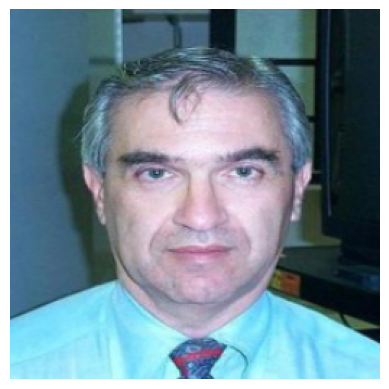

In [8]:
test_loaders(train_loader,dataset.classes_name)

dog


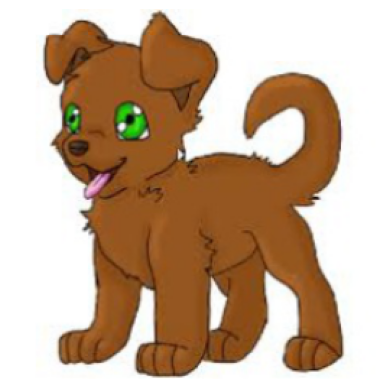

In [9]:
test_loaders(cart_dataloader,dataset.classes_name)

# Defining my CNN and Linear blocks

In [10]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Conv2dBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

In [11]:
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

# Making the model

### you can put your own model here

In [12]:
class myCNN(nn.Module):
    def __init__(self, num_classes):
        super(myCNN,self).__init__()
        self.features = nn.Sequential(
            Conv2dBlock(in_channels=3, out_channels=32),
            Conv2dBlock(in_channels=32, out_channels=64),
            Conv2dBlock(in_channels=64, out_channels=128),
            Conv2dBlock(in_channels=128, out_channels=256),
            Conv2dBlock(in_channels=256, out_channels=512),
        )
        self.flatten = nn.Flatten()
        self.classifier  = nn.Sequential(
            LinearBlock(512 * 8 * 8, 16384, dropout_prob=0.5),
            LinearBlock(16384, 8192, dropout_prob=0.5),
            LinearBlock(8192, 4096, dropout_prob=0.5),
            LinearBlock(4096, 2048, dropout_prob=0.5),
            nn.Linear(2048,num_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# model summary
## uncomment and run

In [13]:
# model = myCNN(len(dataset.classes_num))
# summary(model,torch.zeros((1, 3, 256, 256)))

# Defining the perturbation attacks

### will add explination for each later. the code is taken from chapter 4

In [14]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

# Train a DNN using normal loss

### the DNN is trained like normal and then is test using the test data set.

### then the DNN is tested for DG using the cartoon dataset

In [15]:
model_normal = myCNN(7)
criterion = nn.CrossEntropyLoss()
optimizer_norm = optim.AdamW(model_normal.parameters(), lr=0.001)
exp_scheduler_norm = ExponentialLR(optimizer_norm, gamma=0.90)

In [16]:
losses_normal = train(model_normal,
                      optimizer_norm,
                      criterion,
                      train_loader,
                      val_loader,
                      model_save_path="best_model_normal",
                      scheduler_save_path="normal_lr_schduler",
                      epoch_limit=100)

Epoch 1, Train Loss: 13.1376, Val Loss: 2.1644, Validation Accuracy: 38.32%
new best, model saved new best loss 2.1644030809402466
Epoch 2, Train Loss: 1.5764, Val Loss: 1.5031, Validation Accuracy: 43.41%
new best, model saved new best loss 1.5030888120333354
Epoch 3, Train Loss: 1.3115, Val Loss: 1.3723, Validation Accuracy: 46.11%
new best, model saved new best loss 1.372349222501119
Epoch 4, Train Loss: 1.1894, Val Loss: 1.2652, Validation Accuracy: 49.10%
new best, model saved new best loss 1.2652468085289001
Epoch 5, Train Loss: 1.1175, Val Loss: 1.3017, Validation Accuracy: 49.40%
Epoch 6, Train Loss: 1.0796, Val Loss: 1.2243, Validation Accuracy: 53.89%
new best, model saved new best loss 1.224347194035848
Epoch 7, Train Loss: 1.0607, Val Loss: 1.3092, Validation Accuracy: 52.40%
Epoch 8, Train Loss: 1.0509, Val Loss: 1.2036, Validation Accuracy: 53.89%
new best, model saved new best loss 1.2035722136497498
Epoch 9, Train Loss: 1.0002, Val Loss: 1.1022, Validation Accuracy: 58.

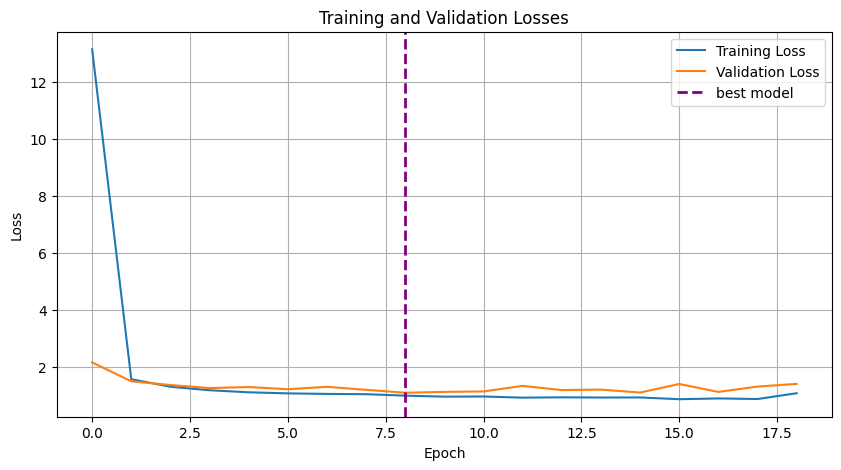

In [18]:
plot_losses(losses_normal)

In [19]:
DNN_tests("/content/best_model_normal",test_loader,cart_dataloader,dataset.num_classes,heading = "Normal model")

Normal model: test set Accuracy: 54.89%
Normal model: DG set Accuracy: 21.08%


# Train a DNN using adversarial loss

### same as the normal DNN above, the DNN is trained like normal and then is test using the test data set.

### then the DNN is tested for DG using the cartoon dataset

In [20]:
model_adv = myCNN(7)
optimizer_adv = optim.Adam(model_adv.parameters(), lr=0.001)
exp_scheduler_adv = ExponentialLR(optimizer_adv, gamma=0.90)

In [21]:
losses = train(model_adv,
               optimizer_adv,
               criterion,
               train_loader,
               val_loader,
               attack = fgsm,
               model_save_path="best_model_adv",
               scheduler_save_path="normal_lr_adv",
               epoch_limit=5)

Epoch 1, Train Loss: 24.9115, Val Loss: 1.5413, Validation Accuracy: 40.72%
new best, model saved new best loss 1.541269600391388
Epoch 2, Train Loss: 1.6077, Val Loss: 1.4595, Validation Accuracy: 44.61%
new best, model saved new best loss 1.4595190684000652
Epoch 3, Train Loss: 1.4622, Val Loss: 1.3732, Validation Accuracy: 43.71%
new best, model saved new best loss 1.3732114632924397
Epoch 4, Train Loss: 1.3610, Val Loss: 1.2922, Validation Accuracy: 47.90%
new best, model saved new best loss 1.2922416925430298
Epoch 5, Train Loss: 1.3380, Val Loss: 1.3280, Validation Accuracy: 47.01%
Epoch limit reached. Training has stopped


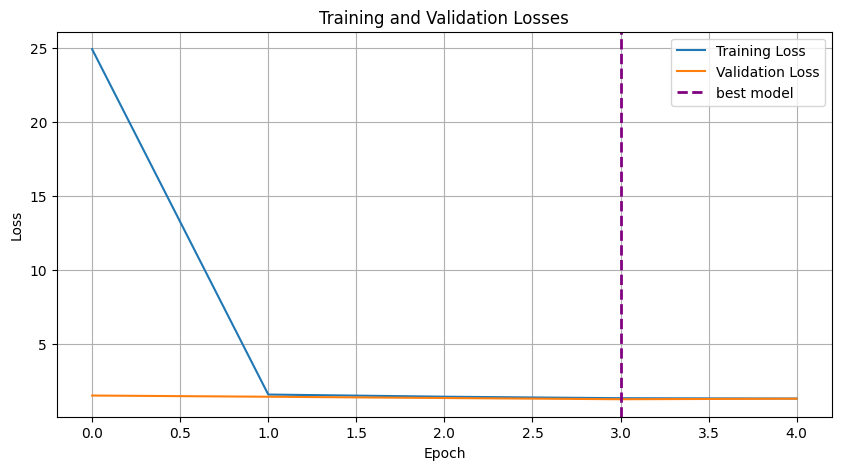

In [22]:
plot_losses(losses)

In [23]:
DNN_tests("/content/best_model_normal",test_loader,cart_dataloader,7,heading="Normal")
DNN_tests("/content/best_model_adv",test_loader,cart_dataloader,7,heading="Adversarial")

Normal: test set Accuracy: 54.89%
Normal: DG set Accuracy: 21.46%
Adversarial: test set Accuracy: 48.12%
Adversarial: DG set Accuracy: 20.14%
